# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  



In [161]:
full_dataset = False

# Import Packages

In [162]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import seaborn as sns

# Data Import and Preparation

In [163]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

train_data = lgb.Dataset(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_train_lightgbm.bin')
validation_data = lgb.Dataset(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_validation_data_lightgbm.bin')

x_train = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_train.csv')
y_train = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_y_train.csv')

x_val = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_val.csv')
y_val = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_y_val.csv').sale  # -> save as pd.Series

x_pred = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_x_pred.csv')

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

In [164]:
# downcast numerical values to reduce mem usage
x_train = utils.reduce_mem_usage(x_train)
x_val = utils.reduce_mem_usage(x_val)
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to  4.77 Mb (74.1% reduction)
Mem. usage of decreased to  0.85 Mb (74.1% reduction)
Mem. usage of decreased to 11.07 Mb (64.7% reduction)


# Model Training & Forecasting (LightGBM)

Run the model in order to analyse its residuals afterwards.

In [165]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20)

y_pred = gbm.predict(x_pred)

Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 1.31808	valid_1's rmse: 1.46571
Early stopping, best iteration is:
[11]	training's rmse: 1.38284	valid_1's rmse: 1.45479


# Training Analysis

Plotting metrics recorded during training...


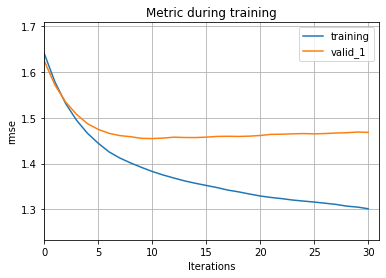

In [166]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

# Residual Analysis

In [167]:
print('*** y_pred ***')
print('min: %0.3f' % np.min(y_pred))
print('5%% Quantile: %0.3f' % np.quantile(y_pred, 0.05))
print('25%% Quantile: %0.3f' % np.quantile(y_pred, 0.25))
print('mean: %0.3f' % np.mean(y_pred))
print('50%% Quantile: %0.3f' % np.quantile(y_pred, 0.5))
print('75%% Quantile: %0.3f' % np.quantile(y_pred, 0.75))
print('95%% Quantile: %0.3f' % np.quantile(y_pred, 0.95))
print('max: %0.3f' % np.max(y_pred))

res = y_val - y_pred
print('\n*** Residuals ***')
print('min: %0.3f' % np.min(res))
print('5%% Quantile: %0.3f' % np.quantile(res, 0.05))
print('25%% Quantile: %0.3f' % np.quantile(res, 0.25))
print('mean: %0.3f' % np.mean(res))
print('50%% Quantile: %0.3f' % np.quantile(res, 0.5))
print('75%% Quantile: %0.3f' % np.quantile(res, 0.75))
print('95%% Quantile: %0.3f' % np.quantile(res, 0.95))
print('max: %0.3f' % np.max(res))

*** y_pred ***
min: 0.210
5% Quantile: 0.235
25% Quantile: 0.263
mean: 0.649
50% Quantile: 0.393
75% Quantile: 0.686
95% Quantile: 1.985
max: 9.980

*** Residuals ***
min: -5.445
5% Quantile: -1.112
25% Quantile: -0.436
mean: 0.024
50% Quantile: -0.263
75% Quantile: 0.314
95% Quantile: 1.838
max: 45.571


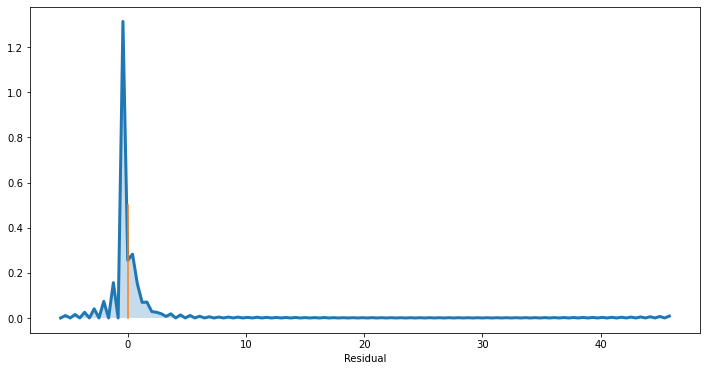

In [168]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.distplot(res, hist=False, kde=True,
                  kde_kws={'shade': True, 'linewidth': 3}, axlabel="Residual")
ax.plot([0, 0], [0, 0.5])

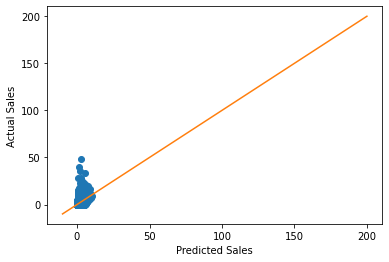

In [169]:
plt.plot(y_pred, y_val, 'o')
plt.xlabel('Predicted Sales')
plt.ylabel('Actual Sales')
plt.plot([-10, 200], [-10, 200])

In [170]:
# Here we compare the target values and the predictions 
# of the time series where the greatest of all outlier occured

index_res_max = np.where(res == np.max(res))[0].item()
id_res_max = int(x_val.iloc[index_res_max, :].item_id)
store_id_res_max = int(x_val.iloc[index_res_max, :].store_id)

y_val_id_res_max = y_val.loc[x_val['item_id'] == id_res_max].loc[x_val['store_id'] == store_id_res_max]

y_pred_id_res_max = pd.Series(y_pred).loc[x_val['item_id'] == id_res_max].loc[x_val['store_id'] == store_id_res_max]


df_res_max = pd.DataFrame({
    'y_true': y_val_id_res_max,
    'y_pred': np.round(y_pred_id_res_max, 2),
    'residual': np.round(y_val_id_res_max - y_pred_id_res_max, 2)
})
df_res_max = df_res_max.reset_index(drop=True)

df_res_max

,y_true,y_pred,residual
0,2.0,1.55,0.45
1,2.0,1.96,0.04
2,0.0,1.44,-1.44
3,0.0,1.57,-1.57
4,8.0,1.77,6.23
5,3.0,1.75,1.25
6,1.0,1.77,-0.77
7,1.0,1.62,-0.62
8,5.0,1.86,3.14
9,3.0,1.57,1.43


### Findings:
- Sales are generally small then predicted (negative median)  
- Some predicted values are negative which makes in context of sales no sense  
- Some great, unpredictable outliers: max residum is 110 whereas 95% quantile: 2.3 

### Approach
- Asymetric loss function to counter skewed distribution 
- Clean data before training e.g. remove outliers

# Approach 1: Custom Loss (asymetric RMSE)

Define custom loss function that is similar to MSE but increase gradient by 10% if residuals are greater than zero (symetric loss function).

In [171]:
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

Run same model as above but with custom loss.

In [172]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid)

y_pred = gbm.predict(x_pred)

Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.36031	valid_1's custom_mse_asymmetric_eval: 1.51466
Early stopping, best iteration is:
[14]	training's custom_mse_asymmetric_eval: 1.41159	valid_1's custom_mse_asymmetric_eval: 1.50653


In [173]:
print('*** y_pred ***')
print('min: %0.3f' % np.min(y_pred))
print('5%% Quantile: %0.3f' % np.quantile(y_pred, 0.05))
print('25%% Quantile: %0.3f' % np.quantile(y_pred, 0.25))
print('mean: %0.3f' % np.mean(y_pred))
print('50%% Quantile: %0.3f' % np.quantile(y_pred, 0.5))
print('75%% Quantile: %0.3f' % np.quantile(y_pred, 0.75))
print('95%% Quantile: %0.3f' % np.quantile(y_pred, 0.95))
print('max: %0.3f' % np.max(y_pred))

res = y_val - y_pred
print('\n*** Residuals ***')
print('min: %0.3f' % np.min(res))
print('5%% Quantile: %0.3f' % np.quantile(res, 0.05))
print('25%% Quantile: %0.3f' % np.quantile(res, 0.25))
print('mean: %0.3f' % np.mean(res))
print('50%% Quantile: %0.3f' % np.quantile(res, 0.5))
print('75%% Quantile: %0.3f' % np.quantile(res, 0.75))
print('95%% Quantile: %0.3f' % np.quantile(res, 0.95))
print('max: %0.3f' % np.max(res))

*** y_pred ***
min: 0.110
5% Quantile: 0.160
25% Quantile: 0.196
mean: 0.602
50% Quantile: 0.328
75% Quantile: 0.631
95% Quantile: 2.027
max: 10.994

*** Residuals ***
min: -6.789
5% Quantile: -1.147
25% Quantile: -0.389
mean: 0.071
50% Quantile: -0.196
75% Quantile: 0.369
95% Quantile: 1.819
max: 45.577


Now we bring the forecasts to the required structure and submit it manually to Kaggle and then compare the performance.

# Printout Forecasts

In [174]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [175]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [176]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [177]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0)  # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]

In [178]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
if full_dataset:
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)

# Conclusion 

Asymetric Loss function led to a major increase in performance (0.66884 to 0.60533) even though the factor of 1.1 is not yet optimized.